<a href="https://colab.research.google.com/github/yanuar-pribadii/Twitter-Hate-Speech-Text-Mining/blob/main/hatespeech_text_mining.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Tugas Text Mining DTI_2020 Muhammad Yanuar Pribadi DS02_16**

Text mining adalah sebuah proses mengekstraksi informasi yang tersembunyi pada sebuah data berbentuk text

Menginstall Natural Language Toolkit dan Sastrawi yang dimana khususnya Sastrawi adalah pengembangan dari proyek PHP Sastrawi. Python Sastrawi merupakan library sederhana yang dapat mengubah kata berimbuhan bahasa Indonesia menjadi bentuk dasarnya

In [2]:
!pip install nltk
!pip install Sastrawi

In [3]:
import pandas as pd
import numpy as np
import nltk
nltk.download('wordnet')
nltk.download('punkt')
import string
import re
from nltk.tokenize import word_tokenize
from nltk.probability import FreqDist
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
factory = StopWordRemoverFactory()
stopword = factory.create_stop_word_remover()
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Merubah data dari bentuk tsv menjadi csv agar lebih mudah diproses

In [4]:
df = pd.read_csv('https://raw.githubusercontent.com/yanuar-pribadii/Twitter-Hate-Speech-Text-Mining/main/IDHSD_RIO_unbalanced_713_2017.csv', encoding = 'latin1')

df

,Label,Tweet
0,Non_HS,RT @spardaxyz: Fadli Zon Minta Mendagri Segera...
1,Non_HS,RT @baguscondromowo: Mereka terus melukai aksi...
2,Non_HS,Sylvi: bagaimana gurbernur melakukan kekerasan...
3,Non_HS,"Ahmad Dhani Tak Puas Debat Pilkada, Masalah Ja..."
4,Non_HS,RT @lisdaulay28: Waspada KTP palsu.....kawal P...
...,...,...
708,HS,Muka Si BABi Ahok Tuh Yg Mirip SERBET Lantai.....
709,HS,"Betul bang hancurkan merka bang, musnahkan chi..."
710,HS,"Sapa Yg bilang Ahok anti korupsi!?, klo grombo..."
711,HS,"Gw juga ngimpi SENTILIN BIJI BABI AHOK, pcetar..."


# **Text Cleaning**

Pada tahap text cleaning ini data text harus dibersihkan dulu agar dapat diolah lebih mudah oleh mesin, tahap tahap nya sebagai berikut

**TOKENIZATION**

Tokenization adalah memisahkan kata, simbol, frase, dan entitas penting lainnya (yang disebut sebagai token) dari sebuah teks untuk kemudian di analisa

In [5]:
#kita copy df menjadi df1 agar membedakan data yang diolah dan belum 
df1 = df.copy()

In [6]:
import nltk
from nltk.tokenize import RegexpTokenizer
nltk.download('punkt')

def tokenizeWords(s, remove_punctuation=True):
    if remove_punctuation == True:
        tokenizer = RegexpTokenizer('\w+|\$[\d\.]+|\S+')
        clean_words = tokenizer.tokenize(s)
    else:
        clean_words = nltk.word_tokenize(s)
    return clean_words

# Tokenize words
df1['tokens'] = df1['Tweet'].apply(tokenizeWords)

df1.head()

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


,Label,Tweet,tokens
0,Non_HS,RT @spardaxyz: Fadli Zon Minta Mendagri Segera...,"[RT, @spardaxyz:, Fadli, Zon, Minta, Mendagri,..."
1,Non_HS,RT @baguscondromowo: Mereka terus melukai aksi...,"[RT, @baguscondromowo:, Mereka, terus, melukai..."
2,Non_HS,Sylvi: bagaimana gurbernur melakukan kekerasan...,"[Sylvi, :, bagaimana, gurbernur, melakukan, ke..."
3,Non_HS,"Ahmad Dhani Tak Puas Debat Pilkada, Masalah Ja...","[Ahmad, Dhani, Tak, Puas, Debat, Pilkada, ,, M..."
4,Non_HS,RT @lisdaulay28: Waspada KTP palsu.....kawal P...,"[RT, @lisdaulay28:, Waspada, KTP, palsu, ........"


**Menghapus tanda baca, simbol, angka**

In [7]:
#import modul regular expression
import re

def removeUselessText(tokens):
    new_tokens = []
    for t in tokens:
        # Remove hashtag
        if not t.startswith('#'):
            # Remove leading & trailing whitespace
            t = t.strip()
            
            # Remove mention
            t = re.sub('@[^\s]+', '', t)

            # Remove urls
            t = re.sub(r'\\/', '/', t) # replace escaped character
            t = re.sub(r'(https?://\S+)', '', t) # remove urls

            # Remove special character and number
            t = re.sub('[^a-zA-Z\s]', '', t)

            new_tokens.append(t)

    return [token for token in new_tokens if token]

df1['no_useless'] = df1['tokens'].apply(removeUselessText)

df1.head()

,Label,Tweet,tokens,no_useless
0,Non_HS,RT @spardaxyz: Fadli Zon Minta Mendagri Segera...,"[RT, @spardaxyz:, Fadli, Zon, Minta, Mendagri,...","[RT, Fadli, Zon, Minta, Mendagri, Segera, Meno..."
1,Non_HS,RT @baguscondromowo: Mereka terus melukai aksi...,"[RT, @baguscondromowo:, Mereka, terus, melukai...","[RT, Mereka, terus, melukai, aksi, dalam, rang..."
2,Non_HS,Sylvi: bagaimana gurbernur melakukan kekerasan...,"[Sylvi, :, bagaimana, gurbernur, melakukan, ke...","[Sylvi, bagaimana, gurbernur, melakukan, keker..."
3,Non_HS,"Ahmad Dhani Tak Puas Debat Pilkada, Masalah Ja...","[Ahmad, Dhani, Tak, Puas, Debat, Pilkada, ,, M...","[Ahmad, Dhani, Tak, Puas, Debat, Pilkada, Masa..."
4,Non_HS,RT @lisdaulay28: Waspada KTP palsu.....kawal P...,"[RT, @lisdaulay28:, Waspada, KTP, palsu, ........","[RT, Waspada, KTP, palsu, kawal, PILKADA, http..."


 **SLANG WORD**

Pada proses slang word ini kita akan mengembalikan kata-kata slang atau bahasa gaul sehari-hari menjadi bahasa baku dan bentuk dasarnya

In [16]:
#mengimport data kata kata slang bahasa indonesia
slang_df = pd.read_csv('https://raw.githubusercontent.com/dhitology/sma-r/master/data/support/Slangword.csv')

# Remove trailing whitespace
slang_df['old'] = slang_df['old'].apply(lambda x: x.strip())
slang_df['new'] = slang_df['new'].apply(lambda x: x.strip())

# Transform into key value paris in a dict
slang_dict = {}
for idx, row in slang_df.iterrows():
    slang_dict.update({row['old']: row['new']})

def replaceSlang(tokens):
    # iterate through tokens
    for i, word in enumerate(tokens):
        # check if token is in slang dictionary
        try:
            tokens[i] = slang_dict[word]
        # if token is not slang pass
        except KeyError:
            pass
    return tokens

df1['no_slang'] = df1['stemmed'].apply(replaceSlang)

df1.head()

,Label,Tweet,tokens,no_useless,stemmed,no_slang,no_stop
0,1,RT @spardaxyz: Fadli Zon Minta Mendagri Segera...,"[RT, @spardaxyz:, Fadli, Zon, Minta, Mendagri,...","[RT, Fadli, Zon, Minta, Mendagri, Segera, Meno...","[rt, fadli, zon, minta, mendagri, segera, nona...","[rt, fadli, zon, minta, mendagri, segera, nona...","[fadli, mendagri, nonaktif, ahok, gubernur, ht..."
1,1,RT @baguscondromowo: Mereka terus melukai aksi...,"[RT, @baguscondromowo:, Mereka, terus, melukai...","[RT, Mereka, terus, melukai, aksi, dalam, rang...","[rt, mereka, terus, luka, aksi, dalam, rangka,...","[rt, mereka, terus, luka, aksi, dalam, rangka,...","[luka, aksi, rangka, penjara, ahok, ahok, gaga..."
2,1,Sylvi: bagaimana gurbernur melakukan kekerasan...,"[Sylvi, :, bagaimana, gurbernur, melakukan, ke...","[Sylvi, bagaimana, gurbernur, melakukan, keker...","[sylvi, bagaimana, gurbernur, laku, keras, per...","[sylvi, bagaimana, gurbernur, laku, keras, per...","[sylvi, gurbernur, laku, keras, perempuan, buk..."
3,1,"Ahmad Dhani Tak Puas Debat Pilkada, Masalah Ja...","[Ahmad, Dhani, Tak, Puas, Debat, Pilkada, ,, M...","[Ahmad, Dhani, Tak, Puas, Debat, Pilkada, Masa...","[ahmad, dhani, tak, puas, debat, pilkada, masa...","[ahmad, dhani, tak, puas, debat, pilkada, masa...","[ahmad, dhani, puas, debat, pilkada, jalan, be..."
4,1,RT @lisdaulay28: Waspada KTP palsu.....kawal P...,"[RT, @lisdaulay28:, Waspada, KTP, palsu, ........","[RT, Waspada, KTP, palsu, kawal, PILKADA, http...","[rt, waspada, ktp, palsu, kawal, pilkada, http...","[rt, waspada, ktp, palsu, kawal, pilkada, http...","[waspada, palsu, kawal, pilkada, https, tcoooo..."


 **STEMMING**
Stemming adalah proses menghilangkan infleksi kata ke bentuk dasarnya, namun bentuk dasar tersebut tidak berarti sama dengan akar kata (root word). Misalnya kata “mendengarkan”, “dengarkan”, “didengarkan” akan ditransformasi menjadi kata “dengar”.

In [8]:
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory

def stemmSentence(tokens):
    # Initiate Sastrawi stemmer
    factory = StemmerFactory()
    stemmer = factory.create_stemmer()

    return [stemmer.stem(t) for t in tokens]

df1['stemmed'] = df1['no_useless'].apply(stemmSentence)

df1.head()

,Label,Tweet,tokens,no_useless,stemmed
0,Non_HS,RT @spardaxyz: Fadli Zon Minta Mendagri Segera...,"[RT, @spardaxyz:, Fadli, Zon, Minta, Mendagri,...","[RT, Fadli, Zon, Minta, Mendagri, Segera, Meno...","[rt, fadli, zon, minta, mendagri, segera, nona..."
1,Non_HS,RT @baguscondromowo: Mereka terus melukai aksi...,"[RT, @baguscondromowo:, Mereka, terus, melukai...","[RT, Mereka, terus, melukai, aksi, dalam, rang...","[rt, mereka, terus, luka, aksi, dalam, rangka,..."
2,Non_HS,Sylvi: bagaimana gurbernur melakukan kekerasan...,"[Sylvi, :, bagaimana, gurbernur, melakukan, ke...","[Sylvi, bagaimana, gurbernur, melakukan, keker...","[sylvi, bagaimana, gurbernur, laku, keras, per..."
3,Non_HS,"Ahmad Dhani Tak Puas Debat Pilkada, Masalah Ja...","[Ahmad, Dhani, Tak, Puas, Debat, Pilkada, ,, M...","[Ahmad, Dhani, Tak, Puas, Debat, Pilkada, Masa...","[ahmad, dhani, tak, puas, debat, pilkada, masa..."
4,Non_HS,RT @lisdaulay28: Waspada KTP palsu.....kawal P...,"[RT, @lisdaulay28:, Waspada, KTP, palsu, ........","[RT, Waspada, KTP, palsu, kawal, PILKADA, http...","[rt, waspada, ktp, palsu, kawal, pilkada, http..."


 **STOP WORD**
Stopword adalah kata umum yang biasanya muncul dalam jumlah besar dan dianggap tidak memiliki makna. Contoh stopword dalam bahasa Indonesia adalah “yang”, “dan”, “di”, “dari”, dll. Makna di balik penggunaan stopword yaitu dengan menghapus kata-kata yang memiliki informasi rendah dari sebuah teks, kita dapat fokus pada kata-kata penting sebagai gantinya.


In [10]:
def removeStopWords(tokens, min_len=3):
    from spacy.lang.id.stop_words import STOP_WORDS

    return [t for t in tokens if t not in STOP_WORDS and len(t)>min_len]

df1['no_stop'] = df1['no_slang'].apply(removeStopWords)

df1.head()

,Label,Tweet,tokens,no_useless,stemmed,no_slang,no_stop
0,Non_HS,RT @spardaxyz: Fadli Zon Minta Mendagri Segera...,"[RT, @spardaxyz:, Fadli, Zon, Minta, Mendagri,...","[RT, Fadli, Zon, Minta, Mendagri, Segera, Meno...","[rt, fadli, zon, minta, mendagri, segera, nona...","[rt, fadli, zon, minta, mendagri, segera, nona...","[fadli, mendagri, nonaktif, ahok, gubernur, ht..."
1,Non_HS,RT @baguscondromowo: Mereka terus melukai aksi...,"[RT, @baguscondromowo:, Mereka, terus, melukai...","[RT, Mereka, terus, melukai, aksi, dalam, rang...","[rt, mereka, terus, luka, aksi, dalam, rangka,...","[rt, mereka, terus, luka, aksi, dalam, rangka,...","[luka, aksi, rangka, penjara, ahok, ahok, gaga..."
2,Non_HS,Sylvi: bagaimana gurbernur melakukan kekerasan...,"[Sylvi, :, bagaimana, gurbernur, melakukan, ke...","[Sylvi, bagaimana, gurbernur, melakukan, keker...","[sylvi, bagaimana, gurbernur, laku, keras, per...","[sylvi, bagaimana, gurbernur, laku, keras, per...","[sylvi, gurbernur, laku, keras, perempuan, buk..."
3,Non_HS,"Ahmad Dhani Tak Puas Debat Pilkada, Masalah Ja...","[Ahmad, Dhani, Tak, Puas, Debat, Pilkada, ,, M...","[Ahmad, Dhani, Tak, Puas, Debat, Pilkada, Masa...","[ahmad, dhani, tak, puas, debat, pilkada, masa...","[ahmad, dhani, tak, puas, debat, pilkada, masa...","[ahmad, dhani, puas, debat, pilkada, jalan, be..."
4,Non_HS,RT @lisdaulay28: Waspada KTP palsu.....kawal P...,"[RT, @lisdaulay28:, Waspada, KTP, palsu, ........","[RT, Waspada, KTP, palsu, kawal, PILKADA, http...","[rt, waspada, ktp, palsu, kawal, pilkada, http...","[rt, waspada, ktp, palsu, kawal, pilkada, http...","[waspada, palsu, kawal, pilkada, https, tcoooo..."


Proses label encoding dimana kata terindikasi Non Hate Speech bernilai 1 dan kata terindikasi Hate Speech bernilai 0

In [11]:
le1 = preprocessing.LabelEncoder()
df1['Label'] =le1.fit_transform(df1['Label'])
df1

,Label,Tweet,tokens,no_useless,stemmed,no_slang,no_stop
0,1,RT @spardaxyz: Fadli Zon Minta Mendagri Segera...,"[RT, @spardaxyz:, Fadli, Zon, Minta, Mendagri,...","[RT, Fadli, Zon, Minta, Mendagri, Segera, Meno...","[rt, fadli, zon, minta, mendagri, segera, nona...","[rt, fadli, zon, minta, mendagri, segera, nona...","[fadli, mendagri, nonaktif, ahok, gubernur, ht..."
1,1,RT @baguscondromowo: Mereka terus melukai aksi...,"[RT, @baguscondromowo:, Mereka, terus, melukai...","[RT, Mereka, terus, melukai, aksi, dalam, rang...","[rt, mereka, terus, luka, aksi, dalam, rangka,...","[rt, mereka, terus, luka, aksi, dalam, rangka,...","[luka, aksi, rangka, penjara, ahok, ahok, gaga..."
2,1,Sylvi: bagaimana gurbernur melakukan kekerasan...,"[Sylvi, :, bagaimana, gurbernur, melakukan, ke...","[Sylvi, bagaimana, gurbernur, melakukan, keker...","[sylvi, bagaimana, gurbernur, laku, keras, per...","[sylvi, bagaimana, gurbernur, laku, keras, per...","[sylvi, gurbernur, laku, keras, perempuan, buk..."
3,1,"Ahmad Dhani Tak Puas Debat Pilkada, Masalah Ja...","[Ahmad, Dhani, Tak, Puas, Debat, Pilkada, ,, M...","[Ahmad, Dhani, Tak, Puas, Debat, Pilkada, Masa...","[ahmad, dhani, tak, puas, debat, pilkada, masa...","[ahmad, dhani, tak, puas, debat, pilkada, masa...","[ahmad, dhani, puas, debat, pilkada, jalan, be..."
4,1,RT @lisdaulay28: Waspada KTP palsu.....kawal P...,"[RT, @lisdaulay28:, Waspada, KTP, palsu, ........","[RT, Waspada, KTP, palsu, kawal, PILKADA, http...","[rt, waspada, ktp, palsu, kawal, pilkada, http...","[rt, waspada, ktp, palsu, kawal, pilkada, http...","[waspada, palsu, kawal, pilkada, https, tcoooo..."
...,...,...,...,...,...,...,...
708,0,Muka Si BABi Ahok Tuh Yg Mirip SERBET Lantai.....,"[Muka, Si, BABi, Ahok, Tuh, Yg, Mirip, SERBET,...","[Muka, Si, BABi, Ahok, Tuh, Yg, Mirip, SERBET,...","[muka, si, babi, ahok, tuh, yg, mirip, serbet,...","[muka, si, babi, ahok, tuh, yg, mirip, serbet,...","[muka, babi, ahok, serbet, lantai]"
709,0,"Betul bang hancurkan merka bang, musnahkan chi...","[Betul, bang, hancurkan, merka, bang, ,, musna...","[Betul, bang, hancurkan, merka, bang, musnahka...","[betul, bang, hancur, merka, bang, musnah, chi...","[betul, bang, hancur, merka, bang, musnah, chi...","[bang, hancur, merka, bang, musnah, china, bab..."
710,0,"Sapa Yg bilang Ahok anti korupsi!?, klo grombo...","[Sapa, Yg, bilang, Ahok, anti, korupsi, !?,, k...","[Sapa, Yg, bilang, Ahok, anti, korupsi, klo, g...","[sapa, yg, bilang, ahok, anti, korupsi, kalau,...","[sapa, yg, bilang, ahok, anti, korupsi, kalau,...","[sapa, bilang, ahok, anti, korupsi, grombolann..."
711,0,"Gw juga ngimpi SENTILIN BIJI BABI AHOK, pcetar...","[Gw, juga, ngimpi, SENTILIN, BIJI, BABI, AHOK,...","[Gw, juga, ngimpi, SENTILIN, BIJI, BABI, AHOK,...","[saya, juga, ngimpi, sentilin, biji, babi, aho...","[saya, juga, ngimpi, sentilin, biji, babi, aho...","[ngimpi, sentilin, biji, babi, ahok, pcetar, p..."


**WORD CLOUD**

Word cloud (disebut juga text cloud atau tag cloud) merupakan salah satu metode untuk menampilkan data teks secara visual. Grafik ini populer dalam text mining karena mudah dipahami. Dengan menggunakan word cloud, gambaran frekuensi kata-kata dapat ditampilkan dalam bentuk yang menarik namun tetap informatif. Semakin sering satu kata digunakan, maka semakin besar pula ukuran kata tersebut ditampilkan dalam word cloud.

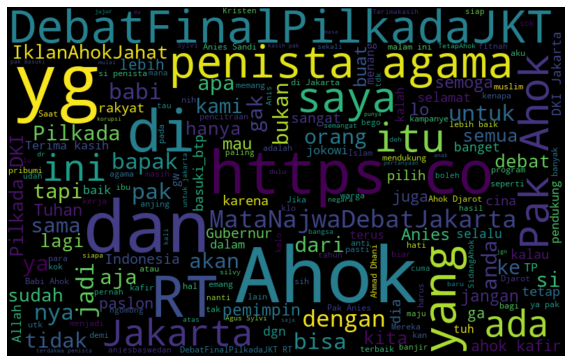

In [12]:
from wordcloud import WordCloud
# imshow-Display data as an image
# interpolation - https://matplotlib.org/3.2.1/gallery/images_contours_and_fields/interpolation_methods.html
all_words = ' '.join([text for text in df1['Tweet'] ])
wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(all_words)
random=0.30
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

In [13]:
tfidf_vectorizer = TfidfVectorizer(ngram_range=(1, 2),max_df=0.75, min_df=5, max_features=10000)

# TF-IDF feature matrix
tfidf = tfidf_vectorizer.fit_transform(df1['Tweet'] )
tfidf

<713x399 sparse matrix of type '<class 'numpy.float64'>'
	with 6405 stored elements in Compressed Sparse Row format>

# **Modelling**

**Naive Bayes**

In [14]:
X = tfidf
y = df1['Label'].astype(int)
X_train_tfidf, X_test_tfidf, y_train, y_test = train_test_split(X.toarray(), y, random_state=42, test_size=0.30)
nbb=GaussianNB()
nbb.fit(X_train_tfidf,y_train)
y_preds = nbb.predict(X_test_tfidf)
acc2b=accuracy_score(y_test,y_preds)
report = classification_report( y_test, y_preds )
print(report)
print("Naive Bayes, Accuracy Score:",acc2b)

              precision    recall  f1-score   support

           0       0.51      0.89      0.65        66
           1       0.93      0.62      0.74       148

    accuracy                           0.71       214
   macro avg       0.72      0.76      0.70       214
weighted avg       0.80      0.71      0.72       214

Naive Bayes, Accuracy Score: 0.705607476635514


**Random Forest Classifier**

In [15]:
X_train_tfidf, X_test_tfidf, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.2)
model = RandomForestClassifier().fit(X_train_tfidf,y_train)
y_preds = model.predict(X_test_tfidf)
report = classification_report( y_test, y_preds )
print(report)
acc=accuracy_score(y_test,y_preds)
print("Random Forest Classifier, Accuracy Score:" , acc)

              precision    recall  f1-score   support

           0       0.82      0.80      0.81        45
           1       0.91      0.92      0.91        98

    accuracy                           0.88       143
   macro avg       0.86      0.86      0.86       143
weighted avg       0.88      0.88      0.88       143

Random Forest Classifier, Accuracy Score: 0.8811188811188811


# **Kesimpulan**

Setelah melakukan text cleaning dan melakukan permodelan, dapat disimpulkan bahwa modelling menggunakan Random Forest memiliki nilai akurasi jauh lebih tinggi dibandingkan Naive Bayes, yaitu **88% berbanding 70%**

Referensi:


1.   https://github.com/dhitology/tm-python/blob/master/005_Hate_Speech.ipynb
2.   https://medium.com/@ksnugroho/dasar-text-preprocessing-dengan-python-a4fa52608ffe

1.   https://www.nurandi.id/blog/membuat-word-cloud-dengan-r/




